# 🤖 Multi-Agent Collaboration with LangGraph

This notebook demonstrates how to build a **multi-agent workflow** using [LangGraph](https://github.com/langchain-ai/langgraph), where two AI agents collaborate to solve a data-driven task. Inspired by the **"divide-and-conquer"** principle, the system splits responsibilities between:

- 🔍 **Research Agent** — Gathers relevant information using a web search tool.
- 📊 **Chart Generator Agent** — Transforms research into Python code and produces visualizations.

The agents communicate and pass context using a **shared memory state**, and their collaboration is orchestrated through a **LangGraph state machine**, allowing turn-by-turn interactions until a "FINAL ANSWER" is produced.

### 🧩 What You'll Learn
- How to define specialized agents using LangChain + LangGraph
- How to build custom tools (e.g., a Python code execution REPL)
- How to manage agent interactions with routing logic
- How to visualize step-by-step multi-agent reasoning

### 🛠 Technologies Used
- [LangGraph](https://langchain-ai.github.io/langgraph/) – for agent orchestration
- [LangChain](https://www.langchain.com/) – for tool and agent abstractions
- [Tavily API](https://www.tavily.com/) – for real-time search
- `seaborn` + Python REPL – for chart generation

> ⚠️ **Note:** The charting agent uses local Python code execution, which should not be used in production without proper sandboxing.

Let's dive in and see how multiple agents can collaborate like a mini autonomous team! 🌐🤝📈


This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

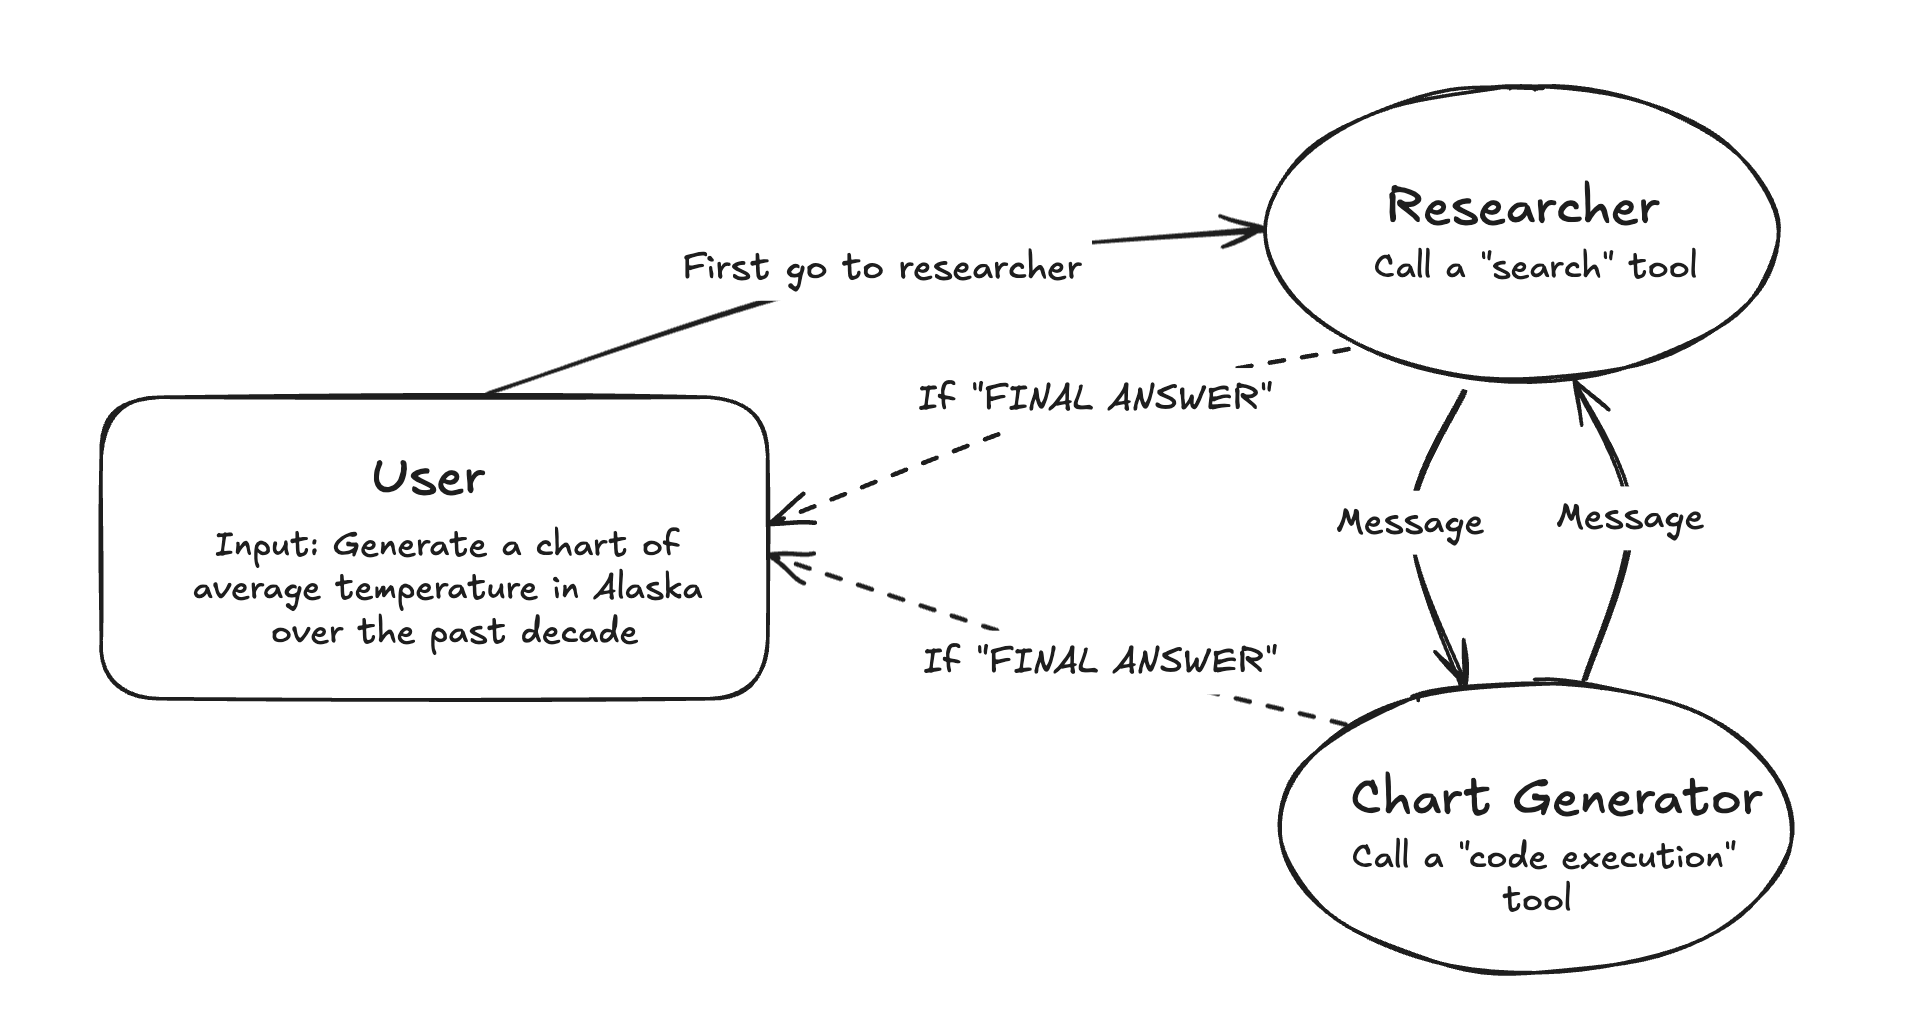


## Setup

First, let's install our required packages and set our API keys:

In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph
%pip install seaborn matplotlib pandas

In [2]:
import getpass
import os

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## 🔧 Tool Definitions

This cell sets up two core tools for the agents:

- `TavilySearchResults`: Enables internet search functionality to fetch real-time data.
- `PythonREPL`: A sandbox-like tool for executing Python code dynamically.

It also defines `python_repl_tool`, a LangChain-compatible wrapper around the Python REPL, allowing the agent to run and return Python code output (e.g., to generate charts).


In [21]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## 🧠 Define Multi-Agent Roles and Routing Logic

This section sets up two collaborative AI agents in a LangGraph workflow:

1. **Research Agent** – Retrieves relevant data using an external tool.
2. **Chart Generator Agent** – Translates research into code and produces charts.

To facilitate collaboration, we use shared system prompts and a routing mechanism (`get_next_node`) that determines when the task is complete by looking for a `"FINAL ANSWER"` signal in the agent responses.

To keep the code modular and readable, we suggest organizing it into three logical parts:


#### 1️⃣ Utility Functions and Routing Logic
- `make_system_prompt(...)`: Creates a role-specific prompt that encourages teamwork and task progression.
- `get_next_node(...)`: A central routing function that determines whether to continue or terminate execution based on message content.

In [ ]:
from typing import Literal
from langchain_openai import ChatOpenAI

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


def make_system_prompt(suffix: str) -> str:
    return f"""You are a helpful AI assistant collaborating with other assistants.
Use the provided tools to progress toward answering the question.
If you are unable to fully answer, that's OK, another assistant with different tools will help where you left off.
Execute what you can to make progress.
Once you or any team member have the final answer or deliverable, prefix your response with "FINAL ANSWER" so the team knows to stop.
{suffix}"""



def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

#### 2️⃣ Research Agent and Node
- Initializes the **research agent** using the `meta-llama` model.
- Configured to use the `tavily_tool` for real-time information retrieval.
- Defines `research_node(...)` to execute the agent, update state, and transition control to the chart generator.

In [ ]:
research_llm = ChatOpenAI(
            openai_api_key=os.getenv("OPENROUTER_API_KEY"),
            openai_api_base=os.getenv("OPENROUTER_BASE_URL"),
            model_name="meta-llama/llama-3.1-8b-instruct")


# Research agent and node
research_agent = create_react_agent(
    research_llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You should only do research to find detailed and accurate data. You are working with a colleague that can write code to generate charts based on the data you provided."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["programmer", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "programmer")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

#### 3️⃣ Chart Generator Agent and Node
- Sets up the **coding/charting agent** using the `gemini` model.
- Uses a Python REPL tool to write and run code (e.g., to create data visualizations).
- The `chart_node(...)` processes the shared state and decides whether to loop back or exit.

Together, these components form a **two-agent collaborative loop** that automatically terminates when either agent produces a final answer.

In [ ]:
programing_llm = ChatOpenAI(
            openai_api_key=os.getenv("OPENROUTER_API_KEY"),
            openai_api_base=os.getenv("OPENROUTER_BASE_URL"),
            model_name="google/gemini-2.0-flash-001")
# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED

programing_agent = create_react_agent(
    programing_llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You should only write code to generate charts. You are working with a researcher colleague that provides you with data and instructions. Use the seaborn library for creating nice visualizations and always show your chart before ending."
    ),
)


def programing_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = programing_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="programmer"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


### Define the Graph

We can now put it all together and define the graph!

In [36]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("programmer", programing_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

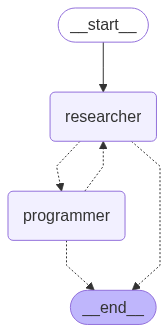

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

In [38]:
%matplotlib inline
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the average monthly temperature in Vancouver and Seattle over the past 10 years and visualize it.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 50},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content='Find the average monthly temperature in Vancouver and Seattle over the past 10 years and visualize it.', additional_kwargs={}, response_metadata={}, id='0b25e576-a0d4-4247-87b8-7ea5ab5a1a65'), AIMessage(content='\n\n<tavily_search_results_json>{"query": "Vancouver average temperature 2010-2020","results": [{"title": "Weather Atlas", "url": "https://www.weather-atlas.com/en/vancouver-canada-10-year-climate-data", "description": "Average temperature in Vancouver, Canada over the past 10 years"}, {"title": "Weatherbase", "url": "https://www.weatherbase.com/comparison-history.php?locID=30736&all=0", "description": "Vancouver, Canada weather history for the past 10 years"}]}</tavily_search_results_json>\n\n<tavily_search_results_json>{"query": "Seattle average temperature 2010-2020","results": [{"title": "Weather Atlas", "url": "https://www.weather-atlas.com/en/seattle-usa-10-year-climate-data", "description": "Average temperature in Seattl

{'researcher': {'messages': [HumanMessage(content='Find the average, min and max annual sallary of a ML Engineer in Vancouver and visualize it using a box plot.', additional_kwargs={}, response_metadata={}, id='de656b47-9d2e-4e27-84b1-906b830964b3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_J3QHHrJSE4xUVUhQMvbHUpeV', 'function': {'arguments': '{"query": "ML Engineer average, min, max salary Vancouver"}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}, {'id': 'call_Ujoz0wL9IEefQk54xlae0DcE', 'function': {'arguments': '{"chart_type": "box plot", "x-axis": "City", "x-values": ["Vancouver"], "y-axis": "salary", "y-values": ["salary average", "salary min", "salary max"]}', 'name': 'create_box_plot'}, 'type': 'function', 'index': 1}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 413, 'total_tokens': 491, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-l

Python REPL can execute arbitrary code. Use with caution.


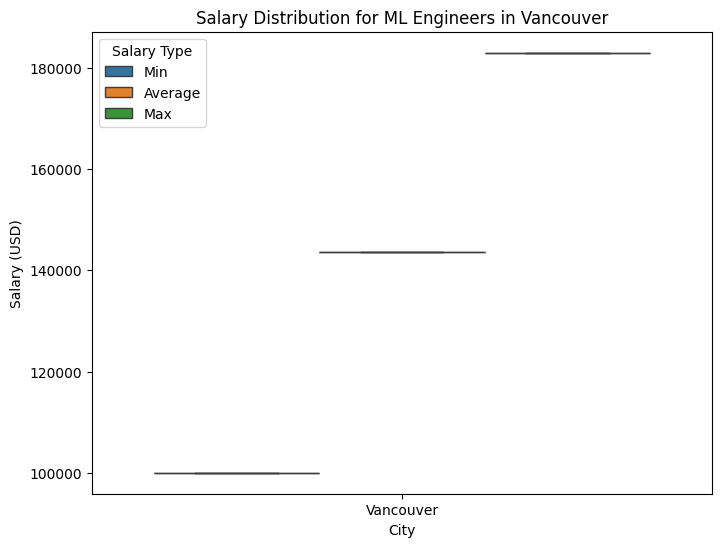

{'programmer': {'messages': [HumanMessage(content='Find the average, min and max annual sallary of a ML Engineer in Vancouver and visualize it using a box plot.', additional_kwargs={}, response_metadata={}, id='de656b47-9d2e-4e27-84b1-906b830964b3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_J3QHHrJSE4xUVUhQMvbHUpeV', 'function': {'arguments': '{"query": "ML Engineer average, min, max salary Vancouver"}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}, {'id': 'call_Ujoz0wL9IEefQk54xlae0DcE', 'function': {'arguments': '{"chart_type": "box plot", "x-axis": "City", "x-values": ["Vancouver"], "y-axis": "salary", "y-values": ["salary average", "salary min", "salary max"]}', 'name': 'create_box_plot'}, 'type': 'function', 'index': 1}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 413, 'total_tokens': 491, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-l

In [15]:
%matplotlib inline
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the average, min and max annual sallary of a ML Engineer in Vancouver and visualize it using a box plot.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 50},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content='First, get historical data on annual GDP Per Capita data for US, China and Canada. Then make a visualization to comapre them. Once you visualized it, finish.', additional_kwargs={}, response_metadata={}, id='29314da6-dfae-4211-9b49-d06e1b30702a'), AIMessage(content='\n\n', additional_kwargs={'tool_calls': [{'id': 'call_DwsiP477QMBeVC1jr6TCG436', 'function': {'arguments': '{"query": "US, China and Canada GDP Per Capita historical data"}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}, {'id': 'call_GeU68Cb8ril5BcIie3qGZ9CK', 'function': {'arguments': '{"query": "chart generator code GDP Per Capita US China Canada"}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 1}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 423, 'total_tokens': 476, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-3.1-8b-i

Python REPL can execute arbitrary code. Use with caution.


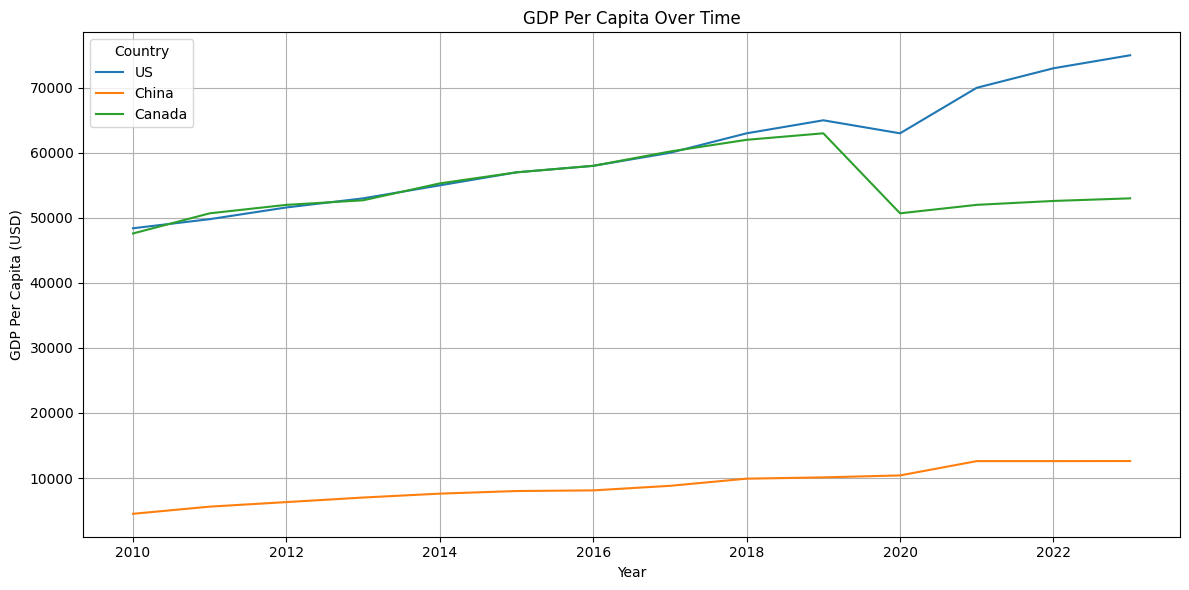

{'programmer': {'messages': [HumanMessage(content='First, get historical data on annual GDP Per Capita data for US, China and Canada. Then make a visualization to comapre them. Once you visualized it, finish.', additional_kwargs={}, response_metadata={}, id='29314da6-dfae-4211-9b49-d06e1b30702a'), AIMessage(content='\n\n', additional_kwargs={'tool_calls': [{'id': 'call_DwsiP477QMBeVC1jr6TCG436', 'function': {'arguments': '{"query": "US, China and Canada GDP Per Capita historical data"}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 0}, {'id': 'call_GeU68Cb8ril5BcIie3qGZ9CK', 'function': {'arguments': '{"query": "chart generator code GDP Per Capita US China Canada"}', 'name': 'tavily_search_results_json'}, 'type': 'function', 'index': 1}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 423, 'total_tokens': 476, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-3.1-8b-i

In [33]:
%matplotlib inline
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get historical data on annual GDP Per Capita data for US, China and Canada. Then make a visualization to comapre them. "
                "Once you visualized it, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 50},
)
for s in events:
    print(s)
    print("----")